Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.BAYOB8_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.BAYOB8_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 222s 88ms/step - accuracy: 0.3362 - loss: 2.8411 - val_accuracy: 0.5739 - val_loss: 1.6465
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 273s 95ms/step - accuracy: 0.5133 - loss: 1.9462 - val_accuracy: 0.5821 - val_loss: 1.5977
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 187s 78ms/step - accuracy: 0.5344 - loss: 1.8503 - val_accuracy: 0.5835 - val_loss: 1.5953
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 185s 78ms/step - accuracy: 0.5405 - loss: 1.8177 - val_accuracy: 0.5814 - val_loss: 1.6138
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 77ms/step - accuracy: 0.5447 - loss: 1.7991 - val_accuracy: 0.5864 - val_loss: 1.5841


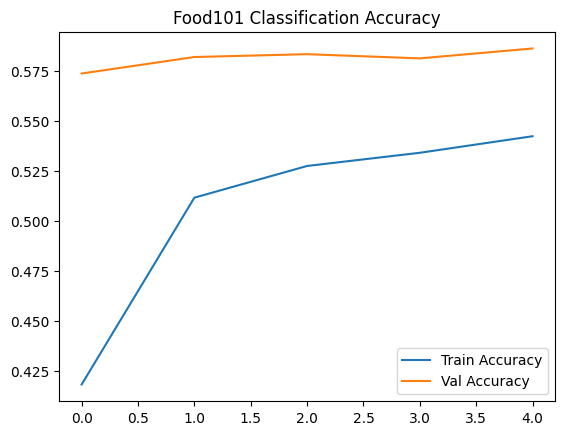

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


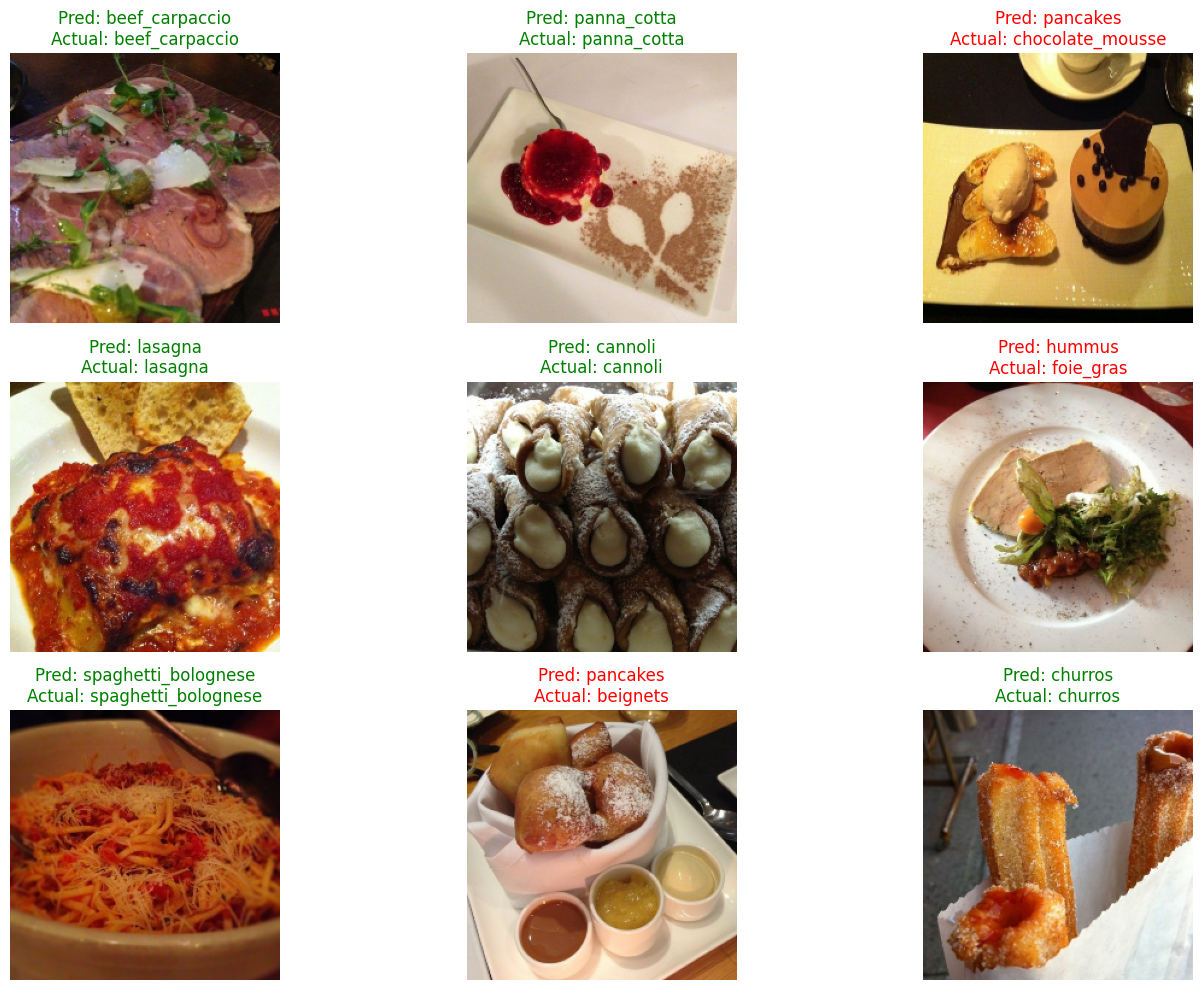

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load dataset
(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Image preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build the model (Transfer Learning)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(101, activation='softmax')  # 101 food categories
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(ds_train, validation_data=ds_test, epochs=5)

# Plot training results
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Food101 Classification Accuracy')
plt.show()
# Get label names
class_names = ds_info.features['label'].names

# Take one batch from the test set
for images, labels in ds_test.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        true_label = class_names[labels[i].numpy()]
        predicted_label = class_names[pred_labels[i].numpy()]
        color = "green" if predicted_label == true_label else "red"
        plt.title(f"Pred: {predicted_label}\nActual: {true_label}", color=color)
    plt.tight_layout()
    plt.show()

